In [142]:
import pandas as pd
import mytools,os
from geographiclib.geodesic import Geodesic
from shapely.geometry import Polygon,Point,LineString,MultiPolygon,MultiLineString 
import geopandas as gpd
from shapely.ops import unary_union

###  导入工参数据

In [143]:
#导入工参数据
gongcan = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/20200712第四版本/1-基础数据/ltejizhan20200616&微站_合并.csv',encoding='gbk'),usecols=[
    '小区CGI(*)','所属地区','小区中文名','RRU经度', 'RRU纬度','天线挂高','工作频段', '方位角','归属区县','厂家名称' ])
#设置变量通用名
print('设置变量通用名')
id = '小区CGI(*)'
lon = 'RRU经度'
lat = 'RRU纬度'
zhishi = '工作频段'
fw = '方位角'

gongcan = gongcan.loc[(gongcan['RRU经度']>108)&
            (gongcan['RRU经度']<117)&
            (gongcan['RRU纬度']>28)&
            (gongcan['RRU纬度']<34)&
           (gongcan['方位角'].notnull())]

设置变量通用名


In [144]:
#只要宏站
gongcan['小区中文名'] = gongcan['小区中文名'].fillna('无')
gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('W-')]
gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('R')]
# gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('M-')]

In [145]:
#替换无效中文名
gongcan['小区中文名'] = gongcan['小区中文名'].fillna('无')
#统计微站的数量
gongcan.loc[gongcan['小区中文名'].str.contains('M-')].shape

(18096, 10)

In [146]:
#打标场景
gongcan = mytools.gisn.points_coverage_merge(gongcan,lon,lat)
#添加覆盖距离
gongcan_loc_juli = mytools.gisn.changjing_distance(gongcan,'区域类型',zhishi)

In [147]:
# #修正农村的覆盖标准距离-可不用
# gongcan_loc_juli.loc[(gongcan_loc_juli['区域类型']=='农村')&(gongcan_loc_juli['工作频段']=='FDD900'),'distance']=1800

In [148]:
gongcan_loc_juli.head(1)

,小区CGI(*),小区中文名,所属地区,RRU经度,RRU纬度,天线挂高,方位角,工作频段,归属区县,厂家名称,区域类型,distance
0,460-00-52246-2,公安群力-ELH-2,荆州,112.14735,30.12405,42.0,157.0,F,公安县,爱立信,农村,1000.0


In [149]:
gongcan_loc_juli.shape

(328065, 12)

### 覆盖模型修正

In [150]:
# 将不同频段和挂高带入公式输出‘使用覆盖半径距离’
gongcan_loc_juli['工作频段'] = gongcan_loc_juli['工作频段'].apply(lambda x: 900 if x=='FDD900' else 1800)
gd,band= map(np.log10, (gongcan_loc_juli['天线挂高'],gongcan_loc_juli['工作频段']))
gongcan_loc_juli['覆盖模型距离'] = np.power(10,
                                      (148 - (46.3+33.9*band-13.82*gd-(-3.81))- 3)/(44.9-6.55*gd))*1000
gongcan_loc_juli['30米覆盖模型距离'] = np.power(10,
                                      (148 - (46.3+33.9*band-13.82*np.log10(30)-(-3.81))- 3)/(44.9-6.55*np.log10(30)))*1000
gongcan_loc_juli['使用覆盖半径'] = gongcan_loc_juli['覆盖模型距离'] /gongcan_loc_juli['30米覆盖模型距离']*gongcan_loc_juli['distance']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [151]:
#限定最大和最小范围
def fc_ik(x):
    if x['区域类型']=='主城区':
        if x['工作频段']==900:
            if x['使用覆盖半径']<200:
                return 200
            elif x['使用覆盖半径']>400:
                return 400
            else:
                return x['distance']
        else:
            if x['使用覆盖半径']<150:
                return 150
            elif x['使用覆盖半径']>350:
                return 350
            else:
                return x['distance']
    elif  x['区域类型']=='县城':
        if x['工作频段']==900:
            if x['使用覆盖半径']<300:
                return 300
            elif x['使用覆盖半径']>430:
                return 430
            else:
                return x['distance']
        else:
            if x['使用覆盖半径']<250:
                return 250
            elif x['使用覆盖半径']>400:
                return 400
            else:
                return x['distance']
    elif  x['区域类型']=='一般城区':
        if x['工作频段']==900:
            if x['使用覆盖半径']<400:
                return 400
            elif x['使用覆盖半径']>1200:
                return 1200
            else:
                return x['distance']
        else:
            if x['使用覆盖半径']<350:
                return 350
            elif x['使用覆盖半径']>800:
                return 800
            else:
                return x['distance']
    elif  x['区域类型']=='乡镇':
        if x['工作频段']==900:
            if x['使用覆盖半径']<430:
                return 430
            elif x['使用覆盖半径']>2200:
                return 2200
            else:
                return x['distance']
        else:
            if x['使用覆盖半径']<400:
                return 400
            elif x['使用覆盖半径']>1000:
                return 1000
            else:
                return x['distance']
    elif  x['区域类型']=='农村':
        if x['工作频段']==900:
            if x['使用覆盖半径']<1200:
                return 1200
            elif x['使用覆盖半径']>2500:
                return 2500
            else:
                return x['distance']
        else:
            if x['使用覆盖半径']<800:
                return 800
            elif x['使用覆盖半径']>1500:
                return 1500
            else:
                return x['distance']
    else:
        return 0

In [152]:
gongcan_loc_juli['distance_use'] = gongcan_loc_juli.apply(fc_ik,axis=1)

In [116]:
gongcan_loc_juli['geometry'][0]

NameError: name 'gongcan_loc_juli' is not defined

In [130]:
gongcan_loc_juli

,小区CGI(*),小区中文名,所属地区,RRU经度,RRU纬度,天线挂高,方位角,工作频段,归属区县,厂家名称,区域类型,distance,覆盖模型距离,30米覆盖模型距离,使用覆盖半径,distance_use
0,460-00-52246-2,公安群力-ELH-2,荆州,112.147350,30.124050,42.0,157.0,1800,公安县,爱立信,农村,1000.0,1597.297478,1382.063443,1155.733831,1000.0
1,460-00-52370-1,公安铜桥-ELH-1,荆州,112.011190,29.883020,38.0,50.0,1800,公安县,爱立信,农村,1000.0,1528.709323,1382.063443,1106.106475,1000.0
2,460-00-52372-1,公安响档口-ELH-1,荆州,112.043460,30.065790,43.0,33.0,1800,公安县,爱立信,农村,1000.0,1614.036174,1382.063443,1167.845211,1000.0
3,460-00-706678-192,枣阳奎园学府S-ZFH-1,襄阳,112.766540,32.145687,26.7,1.0,1800,枣阳市,中兴,县城,350.0,1316.881788,1382.063443,333.493103,350.0
4,460-00-52373-2,公安欣荣-ELH-2,荆州,111.995620,29.858060,38.0,231.0,1800,公安县,爱立信,农村,1000.0,1528.709323,1382.063443,1106.106475,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328126,D_锦绣人家-HLM6261,M-D_锦绣人家-HLM6261,武汉,114.246220,30.624830,4.0,340.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0
328127,D_樊城米公街华容地产-HLM6262,M-D_樊城米公街华容地产-HLM6262,襄阳,112.137600,32.033720,8.0,290.0,1800,NaN,NaN,主城区,250.0,838.459406,1382.063443,151.668039,250.0
328128,D_城区佛星酒楼(微站)-HLM6263,M-D_城区佛星酒楼(微站)-HLM6263,宜昌,111.309644,30.732898,4.0,25.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0
328129,D_汉宜路46号小区-HLM6264,M-D_汉宜路46号小区-HLM6264,武汉,114.229810,30.577370,4.0,180.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0


In [129]:
gongcan_loc_juli['geometry']

KeyError: 'geometry'

In [128]:
gongcan_loc_juli['geometry'][0]

KeyError: 'geometry'

In [153]:
gongcan_loc_juli

,小区CGI(*),小区中文名,所属地区,RRU经度,RRU纬度,天线挂高,方位角,工作频段,归属区县,厂家名称,区域类型,distance,覆盖模型距离,30米覆盖模型距离,使用覆盖半径,distance_use
0,460-00-52246-2,公安群力-ELH-2,荆州,112.147350,30.124050,42.0,157.0,1800,公安县,爱立信,农村,1000.0,1597.297478,1382.063443,1155.733831,1000.0
1,460-00-52370-1,公安铜桥-ELH-1,荆州,112.011190,29.883020,38.0,50.0,1800,公安县,爱立信,农村,1000.0,1528.709323,1382.063443,1106.106475,1000.0
2,460-00-52372-1,公安响档口-ELH-1,荆州,112.043460,30.065790,43.0,33.0,1800,公安县,爱立信,农村,1000.0,1614.036174,1382.063443,1167.845211,1000.0
3,460-00-706678-192,枣阳奎园学府S-ZFH-1,襄阳,112.766540,32.145687,26.7,1.0,1800,枣阳市,中兴,县城,350.0,1316.881788,1382.063443,333.493103,350.0
4,460-00-52373-2,公安欣荣-ELH-2,荆州,111.995620,29.858060,38.0,231.0,1800,公安县,爱立信,农村,1000.0,1528.709323,1382.063443,1106.106475,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328126,D_锦绣人家-HLM6261,M-D_锦绣人家-HLM6261,武汉,114.246220,30.624830,4.0,340.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0
328127,D_樊城米公街华容地产-HLM6262,M-D_樊城米公街华容地产-HLM6262,襄阳,112.137600,32.033720,8.0,290.0,1800,NaN,NaN,主城区,250.0,838.459406,1382.063443,151.668039,250.0
328128,D_城区佛星酒楼(微站)-HLM6263,M-D_城区佛星酒楼(微站)-HLM6263,宜昌,111.309644,30.732898,4.0,25.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0
328129,D_汉宜路46号小区-HLM6264,M-D_汉宜路46号小区-HLM6264,武汉,114.229810,30.577370,4.0,180.0,1800,NaN,NaN,主城区,250.0,669.250824,1382.063443,121.060076,150.0


## 导入天线方向图模型进行建筑物修正 

In [154]:
mx_900 = mytools.othern.pickle_read('G:/mypy/mycloud/jupyter/2_评估/覆盖空洞/20200902评估覆盖空洞-第五版本-覆盖空洞使用天线方向图进行/1-基础数据/44低增益900M0下倾P3_935覆盖模型.data')

In [155]:
#生成天线图的--线条格式
def jm_zl(x,jd_dp,lon,lat,fw,distance):
    jl = int(x[distance])
    lon = x[lon]
    lat = x[lat]
    fw = x[fw]
    jd_dp['distance_use'] = jd_dp['电平_正'].apply(lambda x: x/37.052 *jl)
    jd_dp_use = jd_dp.loc[(jd_dp['角度']<=90) | (jd_dp['角度']>=270)]
    jd_dp_use['角度'] = pd.to_numeric(jd_dp_use['角度'] )
    jd_dp_use['角度2'] = jd_dp_use['角度'].apply(lambda x: x-0+fw if x-0+fw<360 else x-0+fw-360 )
    poy=[]
    dict_use = dict()
    a=0
    for jiao1,jiao2 , jl in zip(jd_dp_use['角度'],jd_dp_use['角度2'],jd_dp_use['distance_use']):
        res = Geodesic.WGS84.Direct(lat, lon, jiao2, jl)
        points=[]
        if int(jiao1)%10==0:
#             print('可以',jiao1,jiao2)
            points.append((lon, lat))
            points.append((res['lon2'], res['lat2']))
            poy.append(LineString(points))
    res_m = MultiLineString(poy)
    return res_m

In [156]:
gongcan_loc_juli.columns 

Index(['小区CGI(*)', '小区中文名', '所属地区', 'RRU经度', 'RRU纬度', '天线挂高', '方位角', '工作频段',
       '归属区县', '厂家名称', '区域类型', 'distance', '覆盖模型距离', '30米覆盖模型距离', '使用覆盖半径',
       'distance_use'],
      dtype='object')

In [157]:
gongcan_loc_wuhan = gongcan_loc_juli.loc[gongcan_loc_juli['归属区县']=='东湖高新开发区']

In [158]:
gongcan_loc_wuhan.shape

(9283, 16)

In [159]:
gongcan_loc_wuhan['geometry'] = gongcan_loc_wuhan.apply(lambda x:jm_zl(x,mx_900,'RRU经度','RRU纬度','方位角','distance_use'),axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [160]:
mytools.dog()

In [201]:
shanxing = gpd.GeoDataFrame(gongcan_loc_wuhan, crs={"init": "epsg:4326"}, geometry='geometry')

In [187]:
a = gongcan_loc_wuhan.loc[gongcan_loc_wuhan.index==322315]

In [190]:
a = gpd.GeoDataFrame(a,geometry='geometry')

In [ ]:
a['geometry'][322315]

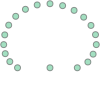

In [196]:
b.boundary

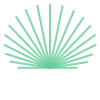

In [195]:
b = a['geometry'][322315]
b

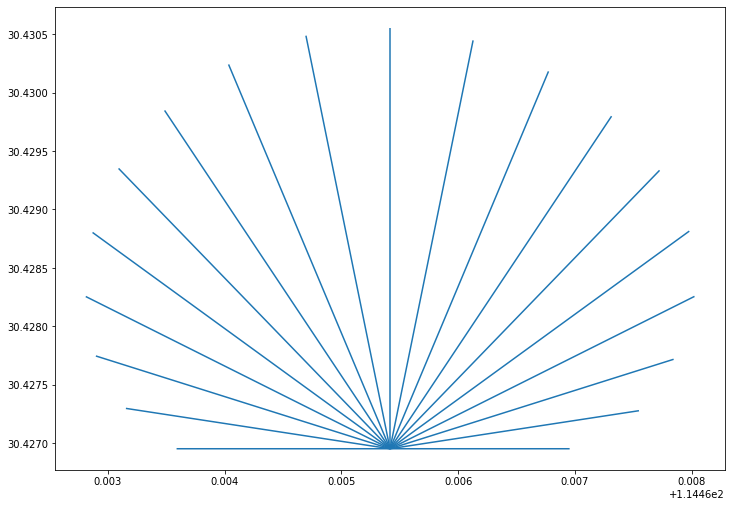

In [191]:
a.plot(figsize=[12,12])

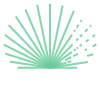

In [207]:
res

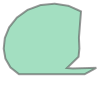

In [209]:
Polygon(linshi_2)

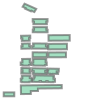

In [210]:
t_jianzhu

In [208]:
mytools.dog()

### 导入建筑物 

In [197]:
#导入数据简单整理下格式
wuhan_jianzhu = gpd.read_file('g:/1-规划/图层/湖北建筑/湖北建筑/湖北建筑/武汉.tab',encoding='gbk')
wuhan_jianzhu_use = wuhan_jianzhu[['建筑物高度','geometry']].reset_index()
wuhan_jianzhu_use = wuhan_jianzhu_use.to_crs({'init': 'epsg:4326'})

In [198]:
wuhan_jianzhu_use.columns = ['index_my', '建筑物高度', 'geometry']

In [199]:
wuhan_jianzhu_use['geo_jz'] =  wuhan_jianzhu_use['geometry']

In [202]:
#与小区覆盖区域求交集
jz_sjoin = gpd.sjoin(shanxing,wuhan_jianzhu_use)

In [203]:
#匹配有交集的数据
jz_sjoin_y = jz_sjoin[['小区CGI(*)','建筑物高度']].drop_duplicates('小区CGI(*)')
shanxing_sjoin = shanxing.merge(jz_sjoin_y,how='left',on='小区CGI(*)',indicator=True)

In [204]:
# #与建筑有交集和与建筑无交集的数据
# shanxing_both = shanxing_sjoin.loc[shanxing_sjoin['_merge']=='both']
# shanxing_left_only = shanxing_sjoin.loc[shanxing_sjoin['_merge']=='left_only']

In [205]:
#过滤掉建筑高度低于基站-5米的
jz_sjoin = jz_sjoin.loc[(jz_sjoin['建筑物高度']-jz_sjoin['天线挂高'])>=5]

In [206]:
#有交集的部分求出遮挡后的扇形
dict_sj = dict()
for cgi,jianzhu in jz_sjoin.groupby('小区CGI(*)'):
    lon=float(jianzhu.head(1)['RRU经度'].values)
    lat=float(jianzhu.head(1)['RRU纬度'].values)
    t_geo = list(jianzhu.head(1)['geometry'])
    t_jianzhu = MultiPolygon([x for x in jianzhu['geo_jz']]).buffer(0.00000001)
    res = t_geo[0].difference(t_jianzhu)
    linshi_2 = []
    for ll in res :
        if (lon, lat) in [x for x in ll.coords[:]]:
            linshi_2.append(ll.coords[-1])
    dict_sj[cgi]=Polygon(linshi_2)

In [ ]:
#转换成df
df_16 = pd.DataFrame.from_dict(dict_sj,orient='index',columns=['jieguo']).reset_index()
df_16.columns = ['小区CGI(*)', 'geo_xiuzeng']

In [ ]:
#修正好的
shanxing_sjoin2 = shanxing_sjoin.merge(df_16,how='left',on='小区CGI(*)')

In [ ]:
#转换geometry
shanxing_sjoin2_1 = gpd.GeoDataFrame(shanxing_sjoin2, geometry='geo_xiuzeng') 

In [ ]:
#过滤出来有房子的
shanxing_ok_fangzi = shanxing_sjoin2_1.loc[shanxing_sjoin2_1.is_ring==True]
#过滤出来么有房子的
shanxing_wu = shanxing_sjoin2_1.loc[shanxing_sjoin2_1.is_ring==False]

In [ ]:
#生成天线图的-多边形格式
def jm_s(x,jd_dp,lon,lat):
    jl = int(x['distance_use'])
    lon = x[lon]
    lat = x[lat]
    fw = x['方位角']
    jd_dp['distance_use'] = jd_dp['电平_正'].apply(lambda x: x/37.052 *jl)
    jd_dp_use = jd_dp.loc[(jd_dp['角度']<=90) | (jd_dp['角度']>=270)]
    jd_dp_use['角度'] = pd.to_numeric(jd_dp_use['角度'] )
    jd_dp_use['角度2'] = jd_dp_use['角度'].apply(lambda x: x-0+fw if x-0+fw<360 else x-0+fw-360 )
    points=[]
    dict_use = dict()
    for jiao , jl in zip(jd_dp_use['角度2'],jd_dp_use['distance_use']):
        res = Geodesic.WGS84.Direct(lat, lon, jiao, jl)
        if int(jiao)%10==0:
            dict_use[jiao]=res['lon2'], res['lat2']
        points.append((res['lon2'], res['lat2']))
    points.append(points[0])
    pol = Polygon(points)
    return pol

In [ ]:
shanxing_wu['geo_xiuzeng'] = shanxing_wu.apply(lambda x:jm_s(x,mx_900,'RRU经度','RRU纬度'),axis=1)

In [ ]:
shanxing_wu = gpd.GeoDataFrame(shanxing_wu, geometry='geo_xiuzeng') 
#将两份数据合并
mx_ok = shanxing_ok_fangzi.append(shanxing_wu)

In [ ]:
mx_ok.shape

In [ ]:
mx_ok.to_pickle('G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/shanxing.data')

# 与地图匹配求出原始空洞

In [ ]:
tu= mytools.gisn.maps('武汉')
tu = tu.loc[tu['区分公司名称']=='东新']

In [ ]:
mx_ok2 = mx_ok.dissolve(by='所属地区')

In [ ]:
kongd_2 = gpd.overlay(tu,mx_ok2,how='difference')

In [ ]:
kongd_2.explode().shape

In [ ]:
kongd_2.to_pickle('G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/kongd.data')

### 达标场景划分大中小 

In [ ]:
kongd_dongxin = kongd_2.explode()

In [ ]:
kongd_dongxin[['lon','lat']] = kongd_dongxin.apply(lambda x:pd.Series(x['geometry'].centroid.coords[:][0]),axis=1)#

In [ ]:
result = mytools.gisn.points_coverage_merge(kongd_dongxin,'lon','lat')

In [ ]:
#添加id编号
result_id = result.reset_index(drop=True)
result['id'] = [ 'kd_{}'.format(str(name)) for name in result_id.index+1]
result['制式'] = 'FDD1800'
result.loc[result['区域类型']=='农村','制式']='FDD900'
result = mytools.gisn.changjing_distance(result,'区域类型','制式')
result = mytools.gisn.add_area(result,'面积')
result['标准面积'] = np.pi* result['distance']* result['distance']
result['空洞面积比例'] = result['面积']/result['标准面积']

In [ ]:
def fuck_data(x):
    if x['空洞面积比例']>=1:
        return '大'
    elif x['空洞面积比例']>=1/3:
        return '中'
    elif x['空洞面积比例']>=1/6:
        return '小'
    else:
        return '微'

In [ ]:
result['空洞级别'] = result.apply(fuck_data,axis=1)

In [ ]:
result.to_pickle('G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/kongd大中小.data')

# 生成kml图层

In [4]:
import math,simplekml

In [5]:
out_file = 'G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/'

## 制作空洞

In [ ]:
result.columns

In [ ]:
use_columns=list(result.columns)

设置变量

In [ ]:
#- 变量 - 设置经纬度和参与循环的字段   
lon,lat,use_id,city = ['lon', 'lat','id','区分公司名称']

In [ ]:
#- 颜色 - 按照字符设置颜色
colour_data = '空洞级别'
colour_dic = {'大':'red','中':'yellow','小':'blue','微':'green','other':'white'}

In [ ]:
#- 标注 -添加标注列
de_col = use_columns
de_col.remove('geometry')

In [ ]:
#- 视野 - 在1400*900的分辨率下  view = 70米对应：125公里（差不多能看到武汉主城区）  700对应1200公里（差不多能看到湖北省）
view = 50000

整理数据

In [ ]:
data_use = result.copy()
#添加标注列
data_use['description']=''
for inde_1, name_1 in enumerate(de_col):
    data_use['linshi']=de_col[inde_1]+' : '+data_use[de_col[inde_1]].astype('str')+'\n'
    data_use['description'] = data_use['description']+data_use['linshi']
    data_use.drop(columns='linshi')

In [ ]:
data_sectors= data_use.copy()
#添加lod的polygon
data_sectors['lod_dis']= view
data_sectors['lon1'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(45* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat1'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(45* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['lon2'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(225* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat2'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(225* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['list_data']=[([lon_1, lat_1,lon_2, lat_2]) 
 for lon_1, lat_1,lon_2, lat_2 in zip(data_sectors['lon1'],data_sectors['lat1'],data_sectors['lon2'],data_sectors['lat2'])]

In [ ]:
df = data_sectors.copy()
#添加颜色列-文字
df['colour']='white'
for name_col in colour_dic:
    df.loc[df[colour_data]==name_col,'colour'] =colour_dic[name_col]

In [ ]:
#最终使用的列
df_use = df.reindex(columns=[city,use_id,colour_data, 'list_data','colour','description','geometry'])   

生成图层

In [ ]:
def make_kml(data_t,name='红色栅格',cc='ff0000ff',xiankuan=0,namea='grid_id',list_data = 'list_data',description='description',minlodpixels=1):
    print(data_t.shape,cc,xiankuan,namea,list_data,description,minlodpixels)
    style = simplekml.Style()
    style.linestyle.color = simplekml.Color.changealphaint(250, cc)  # 最终线条上色
    style.polystyle.outline = xiankuan
    style.polystyle.color = simplekml.Color.changealphaint(250, cc )  # 最终形状上色
    lod1 = simplekml.Lod(minlodpixels=minlodpixels, maxlodpixels=-1,minfadeextent=None, maxfadeextent=None)
    grid_red = kml.newfolder(name=name)
    for grid,list_data ,description_str,geo in zip(data_t[namea],data_t[list_data],data_t[description],data_t['geometry']):
#         pol_r = grid_red.newpolygon(name=grid,outerboundaryis=list_data[0])#栅格使用
        pol_r = grid_red.newpolygon(name=grid,outerboundaryis=list(geo.exterior.coords),innerboundaryis=[po.coords for po in list(geo.interiors)])
        pol_r.description = description_str
        pol_r.altitudemode = simplekml.AltitudeMode.clamptoground
        lon_dd,lat_dd,lon1_dd,lat1_dd = list_data
        latlonaltbox = simplekml.LatLonAltBox(east =lon_dd ,north=lat_dd ,south=lat1_dd ,west=lon1_dd,
                                              minaltitude=None, maxaltitude=None, altitudemode=None)
        pol_r.region.latlonaltbox = latlonaltbox
        pol_r.region.lod = lod1
        pol_r.style=style

In [ ]:
# for name_f in f:#如果是多个文件就使用这个，一个文件不用
#     grid_t = pd.read_pickle(name_f)
#     grid_groupby = grid_t.groupby(['所属地区'])
for cquxian,data_quxian in df_use.groupby(city):
    for name_region,data_region in data_quxian.groupby(colour_data):
        kml = simplekml.Kml()
    #         if not os.path.exists('G:/1-规划/评估/覆盖空洞/2020年6月/2-程序输出/修正覆盖半径/各个地市覆盖图层/{}'.format(name_region)):
    #             os.makedirs('G:/1-规划/评估/覆盖空洞/2020年6月/2-程序输出/修正覆盖半径/各个地市覆盖图层/{}'.format(name_region))
        file = '{}{}空洞_{}_{}.kmz'.format(out_file,cquxian,name_region,data_region.shape[0])
        print('{}开始'.format(file))
        for name_c,data_t in data_region.groupby('colour'):#red:ff0000ff,green:ff008000,yellow:ff00ffff,white:ffffffff,bule:ffff0000
            if 'red' ==name_c:
                make_kml(data_t,name='红色{}个'.format(data_t.shape[0]),cc='ff0000ff',namea=use_id,minlodpixels=50,xiankuan=1)
            elif 'blue' == name_c:
                make_kml(data_t,name='蓝色{}个'.format(data_t.shape[0]),cc='ffff0000',namea=use_id,minlodpixels=50,xiankuan=1)
            elif 'yellow' == name_c:
                make_kml(data_t,name='黄色{}个'.format(data_t.shape[0]),cc='ff00ffff',namea=use_id,minlodpixels=50,xiankuan=1)
            elif 'white' == name_c:
                make_kml(data_t,name='白色{}个'.format(data_t.shape[0]),cc='ffffffff',namea=use_id,minlodpixels=50,xiankuan=1)
            elif 'green'  == name_c:
                make_kml(data_t,name='绿色{}个'.format(data_t.shape[0]),cc='ff008000',namea=use_id,minlodpixels=50,xiankuan=1)
            kml.save(file) if 'kml' in file else kml.savekmz(file, False)
        print('生成图层成功存放在{}'.format(file))
mytools.dog()

## 制作多边形-天线方向图

In [ ]:
data_use = shanxing_ok_fangzi[['小区CGI(*)', '小区中文名', '所属地区', 'RRU经度', 'RRU纬度', '天线挂高', '方位角', '工作频段',
       '归属区县', '厂家名称', '区域类型', 'distance', '覆盖模型距离', '30米覆盖模型距离', '使用覆盖半径',
       'distance_use', '建筑物高度', '_merge', 'geo_xiuzeng']]

In [ ]:
data_use.columns = ['小区CGI(*)', '小区中文名', '所属地区', 'RRU经度', 'RRU纬度', '天线挂高', '方位角', '工作频段',
       '归属区县', '厂家名称', '区域类型', 'distance', '覆盖模型距离', '30米覆盖模型距离', '使用覆盖半径',
       'distance_use', '建筑物高度', '_merge', 'geometry']

In [ ]:
use_columns = list(data_use.columns)

设置变量

In [ ]:
#- 变量 - 设置经纬度和参与循环的字段
lon,lat,use_id,city = ['RRU经度','RRU纬度','小区中文名','归属区县']

In [ ]:
#- 标注 -添加标注列
de_col = use_columns
de_col.remove('geometry')

In [ ]:
#- 视野 - 在1400*900的分辨率下  view = 70米对应：125公里（差不多能看到武汉主城区）  700对应1200公里（差不多能看到湖北省）
view = 50000

整理数据

In [ ]:
#添加标注列
data_use['description']=''
for inde_1, name_1 in enumerate(de_col):
    data_use['linshi']=de_col[inde_1]+' : '+data_use[de_col[inde_1]].astype('str')+'\n'
    data_use['description'] = data_use['description']+data_use['linshi']
    data_use.drop(columns='linshi')

In [ ]:
data_sectors= data_use.copy()
#添加lod的polygon
data_sectors['lod_dis']= view
data_sectors['lon1'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(45* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat1'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(45* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['lon2'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(225* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat2'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(225* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['list_data']=[([lon_1, lat_1,lon_2, lat_2]) 
 for lon_1, lat_1,lon_2, lat_2 in zip(data_sectors['lon1'],data_sectors['lat1'],data_sectors['lon2'],data_sectors['lat2'])]

In [ ]:
df = data_sectors.copy()
#添加颜色列-文字
df['colour']='white'

In [ ]:
df.columns

In [ ]:
#最终使用的列
df_use = df.reindex(columns=[city,use_id, 'list_data','colour','description','geometry'])   

生成图层

In [ ]:
#完整的多边形
def make_kml(data_t,name='红色栅格',cc='ff0000ff',xiankuan=0,namea='grid_id',list_data = 'list_data',description='description',minlodpixels=1):
    print(data_t.shape,cc,xiankuan,namea,list_data,description,minlodpixels)
    style = simplekml.Style()
    style.linestyle.color = simplekml.Color.changealphaint(220, cc)  # 最终线条上色
    style.polystyle.outline = xiankuan
    style.polystyle.color = simplekml.Color.changealphaint(125, cc )  # 最终形状上色
    lod1 = simplekml.Lod(minlodpixels=minlodpixels, maxlodpixels=-1,minfadeextent=None, maxfadeextent=None)
    grid_red = kml.newfolder(name=name)
    for grid,list_data ,description_str,geo in zip(data_t[namea],data_t[list_data],data_t[description],data_t['geometry']):
#         pol_r = grid_red.newpolygon(name=grid,outerboundaryis=list_data[0])#栅格使用
        pol_r = grid_red.newmultigeometry(name=grid)
        pol_r.newpolygon(outerboundaryis=list(geo.exterior.coords),innerboundaryis=[po.coords for po in list(geo.interiors)])
        pol_r.description = description_str
        pol_r.altitudemode = simplekml.AltitudeMode.clamptoground
        lon_dd,lat_dd,lon1_dd,lat1_dd = list_data
        latlonaltbox = simplekml.LatLonAltBox(east =lon_dd ,north=lat_dd ,south=lat1_dd ,west=lon1_dd,
                                              minaltitude=None, maxaltitude=None, altitudemode=None)
        pol_r.region.latlonaltbox = latlonaltbox
        pol_r.region.lod = lod1
        pol_r.style=style

In [ ]:
for name_region,data_region in df_use.groupby(city):
    kml = simplekml.Kml()
    file = '{}覆盖区域_{}_{}.kmz'.format(out_file,name_region,data_region.shape[0])
    for name_c,data_t in data_region.groupby('colour'):#red:ff0000ff,green:ff008000,yellow:ff00ffff,white:ffffffff,bule:ffff0000
        if 'red' ==name_c:
            make_kml(data_t,name='红色{}个'.format(data_t.shape[0]),cc='ff0000ff',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'blue' == name_c:
            make_kml(data_t,name='蓝色{}个'.format(data_t.shape[0]),cc='ffff0000',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'yellow' == name_c:
            make_kml(data_t,name='黄色{}个'.format(data_t.shape[0]),cc='ff00ffff',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'white' == name_c:
            make_kml(data_t,name='白色{}个'.format(data_t.shape[0]),cc='ffffffff',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'green'  == name_c:
            make_kml(data_t,name='绿色{}个'.format(data_t.shape[0]),cc='ff008000',namea=use_id,minlodpixels=50,xiankuan=1)
        kml.save(file) if 'kml' in file else kml.savekmz(file, False)
    print('生成图层成功存放在{}'.format(file))
mytools.dog()

# 建筑物做kml

In [ ]:
jz_sjoin.to_pickle('G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/高的建筑物.data')

In [75]:
jz_sjoin = pd.read_pickle('G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/高的建筑物.data')

In [76]:
jz_sjoin_tu = jz_sjoin[['index_my','建筑物高度','geo_jz']].drop_duplicates('index_my')

In [77]:
jz_sjoin_tu.columns = ['index_my', '建筑物高度', 'geometry']

In [78]:
wuhan_jianzhu_use_2 = gpd.GeoDataFrame(jz_sjoin_tu, crs={"init": "epsg:4326"}, geometry='geometry') 

In [79]:
wuhan_jianzhu_use_2 = wuhan_jianzhu_use_2.reset_index(drop=True)

In [80]:
def polygon3d(x):
    pol = x['geometry']
    c = x['建筑物高度']
    xy= list(pol.exterior.coords)
    if not pol.has_z:
        res =list(zip(*xy))
        res.append([float(c)]*len(xy))
        return Polygon(list(zip(*res)))
    else:
        res =list(zip(*xy))
        res.pop()
        res.append([float(height)]*len(xy))
        return Polygon(list(zip(*res)))

In [81]:
def geo_geogao(x):
    res = []
    pol = x['geometry']
    c = x['建筑物高度']
    for x in pol.exterior.coords[:]:
        a,b =x[:]
        res_p = (a,b,c)
        res.append(res_p)
    return Polygon(res)

In [82]:
wuhan_jianzhu_use_3 = wuhan_jianzhu_use_2.explode()

In [83]:
wuhan_jianzhu_use_4 = wuhan_jianzhu_use_3.loc[wuhan_jianzhu_use_3.is_ring==True]

In [84]:
wuhan_jianzhu_use_4['geometry'] = wuhan_jianzhu_use_4.buffer(0.00000001)

In [85]:
wuhan_jianzhu_use_4['geometry'] = wuhan_jianzhu_use_4.apply(polygon3d ,axis=1)

In [86]:
# wuhan_jianzhu_use_4['geometry'] = wuhan_jianzhu_use_4.apply(geo_geogao ,axis=1)

In [87]:
wuhan_jianzhu_use_4.columns = ['index_my', 'hhh', 'geometry']

In [88]:
data_use = wuhan_jianzhu_use_4.copy()

In [89]:
use_columns = list(data_use.columns)

In [90]:
data_use['city'] = '东新楼宇'
data_use['city2'] = '东新楼宇'

In [91]:
data_use[['lon','lat']] = data_use.apply(lambda x:pd.Series(x['geometry'].centroid.coords[:][0]),axis=1)#

设置变量

In [643]:
wuhan_jianzhu_use_4.columns

Index(['index_my', '建筑物高度', 'geometry'], dtype='object')

In [92]:
data_use = data_use.reset_index(drop=True)

In [104]:
#- 变量 - 设置经纬度和参与循环的字段
lon,lat,use_id,city = ['lon','lat','city','city2']

In [105]:
#- 标注 -添加标注列
de_col = use_columns
de_col.remove('geometry')

ValueError: list.remove(x): x not in list

In [ ]:
#- 视野 - 在1400*900的分辨率下  view = 70米对应：125公里（差不多能看到武汉主城区）  700对应1200公里（差不多能看到湖北省）
view = 50000

整理数据

In [ ]:
#添加标注列
data_use['description']=''
for inde_1, name_1 in enumerate(de_col):
    data_use['linshi']=de_col[inde_1]+' : '+data_use[de_col[inde_1]].astype('str')+'\n'
    data_use['description'] = data_use['description']+data_use['linshi']
    data_use.drop(columns='linshi')

In [ ]:
data_sectors= data_use.copy()
#添加lod的polygon
data_sectors['lod_dis']= view
data_sectors['lon1'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(45* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat1'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(45* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['lon2'] = data_sectors[lon] + data_sectors['lod_dis']*np.sin(225* np.pi/180)*180/( np.pi * 6371229 * np.cos(data_sectors[lat] * np.pi/180))
data_sectors['lat2'] = data_sectors[lat] + data_sectors['lod_dis']*np.cos(225* np.pi/180) / ( np.pi * 6371229 / 180)
data_sectors['list_data']=[([lon_1, lat_1,lon_2, lat_2]) 
 for lon_1, lat_1,lon_2, lat_2 in zip(data_sectors['lon1'],data_sectors['lat1'],data_sectors['lon2'],data_sectors['lat2'])]

In [ ]:
df = data_sectors.copy()
#添加颜色列-文字
df['colour']='white'

In [ ]:
df.columns

In [106]:
#最终使用的列
df_use = df.reindex(columns=[city,use_id, 'list_data','colour','description','geometry'])   

In [107]:
df_use

,city2,city,list_data,colour,description,geometry
0,东新楼宇,东新楼宇,"[114.7928310954752, 30.736760931495905, 114.05...",white,index_my : 284423\nhhh : 13.0\n,"POLYGON Z ((114.42362 30.41879 13.00000, 114.4..."
1,东新楼宇,东新楼宇,"[114.79245073966834, 30.737510279748257, 114.0...",white,index_my : 284428\nhhh : 12.0\n,"POLYGON Z ((114.42363 30.41956 12.00000, 114.4..."
2,东新楼宇,东新楼宇,"[114.79425643967686, 30.735732409021047, 114.0...",white,index_my : 284417\nhhh : 13.0\n,"POLYGON Z ((114.42573 30.41780 13.00000, 114.4..."
3,东新楼宇,东新楼宇,"[114.79362047498982, 30.736082544118013, 114.0...",white,index_my : 284421\nhhh : 13.0\n,"POLYGON Z ((114.42440 30.41814 13.00000, 114.4..."
4,东新楼宇,东新楼宇,"[114.75991122311679, 30.82661944708117, 114.02...",white,index_my : 238269\nhhh : 37.0\n,"POLYGON Z ((114.39159 30.50883 37.00000, 114.3..."
...,...,...,...,...,...,...
7501,东新楼宇,东新楼宇,"[114.74522985953578, 30.827079850888357, 114.0...",white,index_my : 237166\nhhh : 10.0\n,"POLYGON Z ((114.37605 30.50922 10.00000, 114.3..."
7502,东新楼宇,东新楼宇,"[114.74540914993115, 30.827228582283812, 114.0...",white,index_my : 237086\nhhh : 20.0\n,"POLYGON Z ((114.37606 30.50932 20.00000, 114.3..."
7503,东新楼宇,东新楼宇,"[114.74466623493794, 30.827290637738546, 114.0...",white,index_my : 236946\nhhh : 23.0\n,"POLYGON Z ((114.37541 30.50929 23.00000, 114.3..."
7504,东新楼宇,东新楼宇,"[114.74481153292815, 30.825986585327126, 114.0...",white,index_my : 236951\nhhh : 17.0\n,"POLYGON Z ((114.37553 30.50807 17.00000, 114.3..."


生成图层

In [114]:
#复杂的多边形
def make_kml(data_t,name='红色栅格',cc='ff0000ff',xiankuan=0,namea='grid_id',list_data = 'list_data',description='description',minlodpixels=1):
    print(data_t.shape,cc,xiankuan,namea,list_data,description,minlodpixels)
    style = simplekml.Style()
    style.linestyle.color = simplekml.Color.changealphaint(200, cc)  # 最终线条上色
    style.polystyle.outline = xiankuan
    style.polystyle.color = simplekml.Color.changealphaint(150, cc )  # 最终形状上色
    lod1 = simplekml.Lod(minlodpixels=minlodpixels, maxlodpixels=-1,minfadeextent=None, maxfadeextent=None)
    grid_red = kml.newfolder(name=name)
    for grid,list_data ,description_str,geo in zip(data_t[namea],data_t[list_data],data_t[description],data_t['geometry']):
#         print(grid,list_data ,description_str,geo)
        if geo.type == 'MultiPolygon':
            pol_r = grid_red.newmultigeometry(name=grid)
            for geo_t in geo: # Generate longitude values
                pol_r.newpolygon(name=grid,outerboundaryis=list(geo_t.exterior.coords),innerboundaryis=[po.coords for po in list(geo_t.interiors)])
        else:
            pol_r = grid_red.newpolygon(name=grid,outerboundaryis=list(geo.exterior.coords),innerboundaryis=[po.coords for po in list(geo.interiors)])
        pol_r.description = description_str
#         pol_r.altitudemode = simplekml.AltitudeMode.clamptoground
        pol_r.altitudemode = simplekml.AltitudeMode.relativetoground
        pol_r.extrude = 1
        lon_dd,lat_dd,lon1_dd,lat1_dd = list_data
        latlonaltbox = simplekml.LatLonAltBox(east =lon_dd ,north=lat_dd ,south=lat1_dd ,west=lon1_dd,
                                              minaltitude=None, maxaltitude=None, altitudemode=None)
        pol_r.region.latlonaltbox = latlonaltbox
        pol_r.region.lod = lod1
        pol_r.style=style

In [115]:
for name_region,data_region in df_use.groupby(city):
    kml = simplekml.Kml()
    file = '{}{}_{}.kmz'.format(out_file,name_region,data_region.shape[0])
    for name_c,data_t in data_region.groupby('colour'):#red:ff0000ff,green:ff008000,yellow:ff00ffff,white:ffffffff,bule:ffff0000
        if 'red' ==name_c:
            make_kml(data_t,name='红色{}个'.format(data_t.shape[0]),cc='ff0000ff',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'blue' == name_c:
            make_kml(data_t,name='蓝色{}个'.format(data_t.shape[0]),cc='ffff0000',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'yellow' == name_c:
            make_kml(data_t,name='黄色{}个'.format(data_t.shape[0]),cc='ff00ffff',namea=use_id,minlodpixels=50,xiankuan=1)
        elif 'white' == name_c:
            print('白色')
            make_kml(data_t,name='白色{}个'.format(data_t.shape[0]),cc='ff800080',namea=use_id,minlodpixels=50,xiankuan=1)#紫色ff800080,ffffffff
        elif 'green'  == name_c:
            make_kml(data_t,name='绿色{}个'.format(data_t.shape[0]),cc='ff008000',namea=use_id,minlodpixels=50,xiankuan=1)
        kml.save(file) if 'kml' in file else kml.savekmz(file, False)
    print('生成图层成功存放在{}'.format(file))
mytools.dog()

白色
(7506, 6) ff800080 1 city list_data description 50
生成图层成功存放在G:/1-规划/评估/覆盖空洞/20200928成功修正站高的影响/输出数据/东新楼宇_7506.kmz


In [37]:
df_use['description'][0]

'index_my : 284423\nhhh : 13.0\n'